# Tutorial

In [1]:
import sys
import os
import time
# Add the path to the parent module
sys.path.append(os.path.abspath('../..'))

In [2]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np

from deeppy import LearnFrame, DataGetter
from deeppy.models.network import Network
from deeppy.models.network_utils import LayerGenerator
from deeppy.models.autoencoder.b_vae import B_Vae


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
from torchvision import datasets
from torchvision.transforms import ToTensor
training_data = datasets.FashionMNIST(
    root="datasets",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="datasets",
    train=False,
    download=True,
    transform=ToTensor()
)

X = training_data.train_data.unsqueeze(1) / 255
data = DataGetter(X=X,y=X, batch_size = 128)

/home/boz/anaconda3/envs/deeppy/lib/python3.13/site-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [4]:
latent_size = 10

kernel = 4
stride = 1
padding = 0

e_cnn_arch = {
            "layers":[1,128,64,32,16],
            "blocks":[nn.Conv2d, nn.BatchNorm2d, nn.LeakyReLU],
            "block_args": [{"kernel_size" : kernel, "stride":stride, "padding"  : padding} ],
            "out_act":nn.LeakyReLU,
            "weight_init":"uniform",
}

e_flatten_arch = {
    "blocks" : [nn.Flatten]
}

e_dense_arch = {
    "layers":[4096, latent_size * 2],
    "blocks":[nn.Linear],
    "block_args":[],
    "out_act":nn.Identity,
    "weight_init":"uniform",
}

d_dense_arch = {
    "layers":[latent_size, 4096],
    "blocks":[nn.Linear],
    "block_args":[],
    "out_act":nn.Identity,
    "weight_init":"uniform",
}



class ImageShape(nn.Module):
    def __init__(self, shape):
        super(ImageShape, self).__init__()
        self.shape = shape
    def forward(self, x):
        return x.view((-1, *self.shape))

d_image_arch = {
    "blocks":[ImageShape],
    "block_args":[{"shape" : (16,16,16)}],
}

d_cnn_arch1 = {
            "layers":[16,32,64,128],
            "blocks":[nn.ConvTranspose2d, nn.BatchNorm2d, nn.LeakyReLU],
            "block_args": [{"kernel_size" : 4, "stride":1, "padding"  : 0} ],
            "out_act":nn.LeakyReLU,
            "weight_init":"uniform",
}

d_cnn_arch2 = {
            "layers":[128,1],
            "blocks":[nn.ConvTranspose2d],
            "block_args": [{"kernel_size" : 4, "stride":1, "padding"  : 0} ],
            "out_act":nn.Sigmoid,
            "weight_init":"uniform",
}








encoder_params = [e_cnn_arch, e_flatten_arch, e_dense_arch]
decoder_params  = [d_dense_arch, d_image_arch, d_cnn_arch1, d_cnn_arch2]

network_params = {
    "arch_params" : encoder_params, 
    "decoder_params" : decoder_params, 
    "task" :"autoencoder", 
}

net = Network(**network_params)
print(net)
print("----------")
X,y = data.train_data()
print(X.shape)
#print(f"out shpae : {net(X).shape}")

Network(
  (model): Sequential(
    (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(128, 64, kernel_size=(4, 4), stride=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(64, 32, kernel_size=(4, 4), stride=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2d(32, 16, kernel_size=(4, 4), stride=(1, 1))
    (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=4096, out_features=20, bias=True)
    (14): Identity()
    (15): Linear(in_features=10, out_features=4096, bias=True)
    (16): Identity()
 

In [7]:
bvae_params = {
    "network_params" : network_params,
    "device" : device,
    "beta" : 1e-1,
    "criterion" : nn.MSELoss()
}


model = B_Vae(**bvae_params)
#net = Network(**network_params)
#print(net)
#print("----------")
#print(f"out shpae : {net(data.train_data()).shape}")

#model = B_Vae.load("checkpoint/b_vae.pt")

In [8]:
lf = LearnFrame(model, data)

<Figure size 640x480 with 0 Axes>

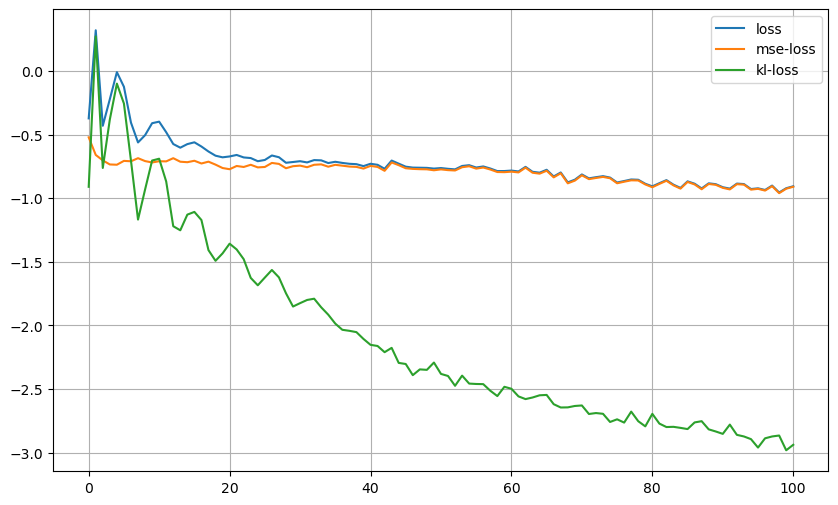

<Figure size 640x480 with 0 Axes>

In [ ]:
for i in range(2000):
    lf.optimize()
    if i % 100 ==0:
        lf.plot([np.log10(np.asarray(lf.train_data).T)], labels = [["loss","mse-loss","kl-loss"]])
lf.plot([np.log10(np.asarray(lf.train_data).T)], labels = [["loss","mse-loss","kl-loss"]],show_result= True)

In [39]:
lf.save("checkpoints/b_vae")

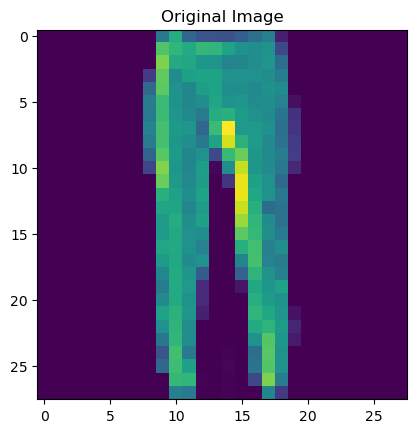

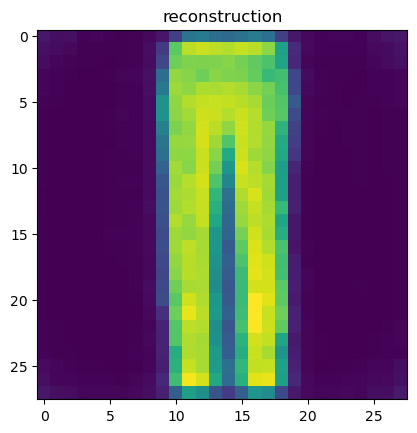

In [26]:
im, _ = data.train_data()
plt.imshow(im[0,0])
plt.title("Original Image")
plt.show()

reconstruction, mu, log_var = model.predict(im)

reconstruction,mu,log_var = reconstruction.detach().cpu().numpy(), mu.detach().cpu().numpy(), log_var.detach().cpu().numpy()
plt.imshow(reconstruction[0,0])
plt.title("reconstruction")
plt.show()

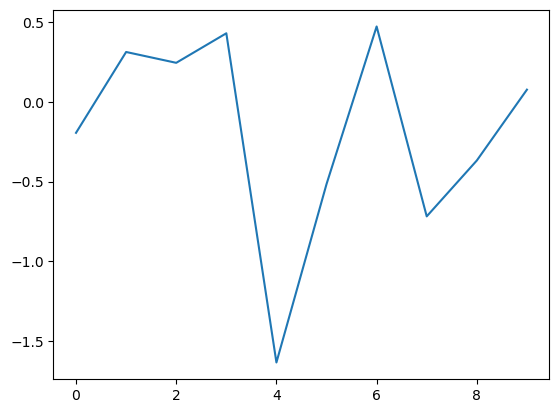

In [27]:
plt.plot(mu[0])

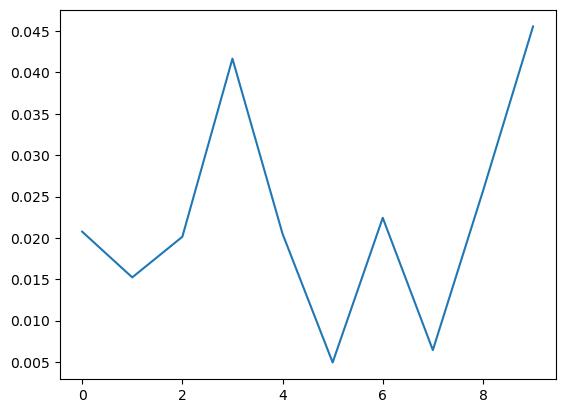

In [28]:
plt.plot(log_var[0])